# Principal components analysis for order parameter construction

In [3]:
from analysis_tools.read_traj import ReadTraj
from analysis_tools.feature_creation import FrameToFeaturesPosition, TrajectoryToFeaturesPosition
from analysis_tools.feature_creation import FrameToFeaturesComposition, TrajectoryToFeaturesComposition
from analysis_tools.radial_distribution_function import RDF
from IPython.display import clear_output

In [2]:
def DownSampleFrames(frames, frame_samples):
    return frames[0::max(len(frames)/frame_samples, 1)][0:frame_samples]

---

## Models

In [6]:
from numpy import array, arange

### Model data

#### Hard disks

In [48]:
N_nn = 5000 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
####particle_inc = 1000 #skip this many particles in generating features
nn_inc = 5 #reduces the number of nearest neighbors to include as features
####method = ['distance']
remove_types = []
shuffle_data = True
N_batch = 1
batches_per_frame = 10

In [49]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.550, 0.690001, 0.005), '../hoomd_disks/trajectories_4000p', 100000), 
             (arange(0.695, 0.820001, 0.005),'../hoomd_disks/trajectories_4000p_longer', 100000)]

#### Hard spheres

In [207]:
N_nn = 5000 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
particle_inc = 200 #skip this many particles in generating features
nn_inc = 5 #reduces the number of nearest neighbors to include as features
method = ['distance']
remove_types = []
shuffle_data = True

In [208]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.400, 0.695001, 0.005), '../hoomd_spheres/trajectories_4000p')]

Branches

In [28]:
N_nn = 5000 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
####particle_inc = 10 #skip this many particles in generating features
nn_inc = 5 #reduces the number of nearest neighbors to include as features
####method = ['distance']
remove_types = []
shuffle_data = True
N_batch = 2
batches_per_frame = 100

In [158]:
#actual data for training and modeling
traj_type = 'gsd'
file_data = [(arange(0.400, 0.525001, 0.005), '../hoomd_spheres/trajectories_4000p', 200), 
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_1/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_2/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_3/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_4/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_5/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_6/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_7/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_8/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_9/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_10/trajectories/', 20)]

#any reference data for comparison
ref_traj_type = 'xyz'
ref_file_data = [(arange(0.400, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/fcc_reference/', 1)]

#### Widom-Rowlinson

In [3]:
N_nn = 50 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
####particle_inc = 200 #skip this many particles in generating features
nn_inc = 1 #reduces the number of nearest neighbors to include as features
####method = ['distance']
remove_types = []# ['B']
shuffle_data = True
N_batch = 10
batches_per_frame = 1

In [4]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.100, 2.06001, 0.04), '../hoomd_disks/trajectories_ww_4000p')]

In [5]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.100, 3.50001, 0.04), '../hoomd_disks/trajectories_ww_4000p_0.25')]

### Density range and color ids for plotting

In [9]:
#actual data
etas = []
[etas.extend(etas_) for etas_, _, _ in file_data]
etas = array(etas)
color_ids = []
[color_ids.extend(len(data[0])*[count]) for count, data in zip(range(len(file_data)), file_data)]
color_ids = array(color_ids)

In [ ]:
#reference data
ref_etas = []
[ref_etas.extend(etas_) for etas_, _, _ in ref_file_data]
ref_etas = array(ref_etas)
ref_color_ids = []
[ref_color_ids.extend(len(data[0])*[count]) for count, data in zip(range(len(ref_file_data)), ref_file_data)]
ref_color_ids = array(ref_color_ids)

---

## Perfom PCA

In [10]:
from numpy import array_split
from sklearn.decomposition import IncrementalPCA

### Train on ideal gas structure first to identify trivial variance contributions

The purpose is to transform the features into new features that are uncorrelated and of equal variance when applied to the ideal gas

This is not always useful as some features naturally will obey this ideal gas limit, though there is no harm to do it other than computational cost

The rationale for this is twofold:
1. Intuitively, there should be nothing to "learn" from the ideal (this is the maximally random disordered state)
2. Practically speaking, performing this yields a cleaned up eigenvalue spectrum, zeroing in on the actually relevent order parameters and not trivial order parameters that describe ideal gas correlations trivially induced by feature construction

<img src="./supplemental_files/whitening.jpg" style="float: left;" width="900">

In [55]:
n_components_ig = 1638 #3276 #819 (HS positional)     #205 (WW positional)

In [56]:
incpca_ig = IncrementalPCA(n_components=n_components_ig, whiten=True)  #NOTICE: whitening is on here

frames = None
features = None
split_features = None

for etas_, file_base, frame_samples in file_data:
    for eta in etas_:
        print 'file_base={}'.format(file_base)
        print 'eta={}'.format(eta)
        filename = "{}/trajectory_{:.4f}.{}".format(file_base, eta, traj_type)
        frames = ReadTraj(filename, traj_type, shuffle_data, True, remove_types)
        frames = DownSampleFrames(frames, frame_samples) ##############
        print 'Using {} frames'.format(len(frames))
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeaturesPosition(frames_partial, 
                                                            N_nn=N_nn, 
                                                            ####method=method, 
                                                            ####particle_inc=particle_inc, 
                                                            nn_inc=nn_inc,
                                                            N_batch=N_batch, 
                                                            batches_per_frame=batches_per_frame)
            incpca_ig.partial_fit(features_partial)

        clear_output()
        frames_split = None

### Train on actual data with trivial ideal gas correlations removed

In [59]:
n_components = n_components_ig  #these need not be equal but why not keep them all unless too computationally demanding

In [60]:
incpca = IncrementalPCA(n_components=n_components, whiten=False)  #NOTE: not whitening here

frames = None
features = None
split_features = None

for etas_, file_base, frame_samples in file_data:
    for eta in etas_:
        print 'file_base={}'.format(file_base)
        print 'eta={}'.format(eta)
        filename = "{}/trajectory_{:.4f}.{}".format(file_base, eta, traj_type)
        frames = ReadTraj(filename, traj_type, shuffle_data, False, remove_types)
        frames = DownSampleFrames(frames, frame_samples) ##############
        print 'Using {} frames'.format(len(frames))
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeaturesPosition(frames_partial, 
                                                            N_nn=N_nn, 
                                                            ####method=method, 
                                                            ####particle_inc=particle_inc, 
                                                            nn_inc=nn_inc,
                                                            N_batch=N_batch, 
                                                            batches_per_frame=batches_per_frame)
            incpca.partial_fit(incpca_ig.transform(features_partial))

        clear_output()
        frames_split = None

### Compute the order parameters based on two nested models

In [66]:
frames = None
features = None
raw_OPs = []

for etas_, file_base, frame_samples in file_data:
    for eta in etas_:
        print 'file_base={}'.format(file_base)
        print 'eta={}'.format(eta)
        filename = "{}/trajectory_{:.4f}.{}".format(file_base, eta, traj_type)
        frames = ReadTraj(filename, traj_type, shuffle_data, False, remove_types)
        frames = DownSampleFrames(frames, frame_samples) ##############
        print 'Using {} frames'.format(len(frames))
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeaturesPosition(frames_partial, 
                                                            N_nn=N_nn, 
                                                            ####method=method, 
                                                            ####particle_inc=particle_inc, 
                                                            nn_inc=nn_inc,
                                                            N_batch=N_batch, 
                                                            batches_per_frame=batches_per_frame)
            transformed_features_partial = incpca.transform(incpca_ig.transform(features_partial))
            raw_OPs_single.append(transformed_features_partial)

        clear_output()
        raw_OPs.append(raw_OPs_single)  

### Developing single loop version for all steps
---

In [50]:
#define our pca models and let it discover the dimensionality (need to check later that #rows > #columns though)
incpca_ig = IncrementalPCA(n_components=None, whiten=True)  #whitening is ON
incpca = IncrementalPCA(n_components=None, whiten=False)  #whitening is OFF

#intermediate variables
frames = None
features = None

#output variables
raw_OPs = []

#for controlling the status printing
print_count = 1
max_print = 2

#perform all of the modeling phases in one fell swoop
for phase in ['fit_whitener', 'fit_model', 'compute_ops']:
    
    #loop over data sets 
    for etas_, file_base, frame_samples in file_data:

        #loop over statepoints within a given data set
        for eta in etas_:
            print 'COMPUTATION DETAILS'
            print 'phase = {}'.format(phase)
            print 'file_base = {}'.format(file_base)
            print 'eta = {}'.format(eta)
            
            #read in data and randomize positions if performing ideal gas correction
            filename = "{}/trajectory_{:.4f}.{}".format(file_base, eta, traj_type)
            randomize = (phase == 'fit_whitener')
            frames = ReadTraj(filename, traj_type, shuffle_data, randomize, remove_types)
            
            #control the number of total frames to analyze
            len_frames_init = len(frames)
            frames = DownSampleFrames(frames, frame_samples)
            print 'using {} frames of {} total'.format(len(frames), len_frames_init)
            
            #split the frames for memory purposes
            frames_split = array_split(frames, split)
            frames = None
            
            #loop over the split data for memory management
            raw_OPs_single = []
            for frames_partial in frames_split:
                features_partial = TrajectoryToFeaturesPosition(frames_partial, 
                                                                N_nn=N_nn,  
                                                                nn_inc=nn_inc,
                                                                N_batch=N_batch, 
                                                                batches_per_frame=batches_per_frame)

                #check that n_rows > n_columns as this is neccesary for accuracy and the ideal gas transformation to be valid
                if features_partial.shape[0] < features_partial.shape[1]:
                    raise Exception('The partial feature set has less rows than columns!')
                print 'partial feature shape = {}'.format(features_partial.shape)

                #perform the various model phases
                if phase == 'fit_whitener': 
                    incpca_ig.partial_fit(features_partial)
                elif phase == 'fit_model':
                    incpca.partial_fit(incpca_ig.transform(features_partial))
                elif phase == 'compute_ops' :
                    transformed_features_partial = incpca.transform(incpca_ig.transform(features_partial))
                    raw_OPs_single.append(transformed_features_partial)

            #print control
            print '\n'
            if print_count % max_print == 0:
                clear_output()
            print_count+=1

            if phase == 'compute_ops':
                raw_OPs.append(raw_OPs_single)  

COMPUTATION DETAILS
phase = compute_ops
file_base = ../hoomd_disks/trajectories_4000p_longer
eta = 0.82
using 1000 frames of 1000 total
partial feature shape = (10000, 819)




---

### Compute order parameter stats

In [51]:
from numpy import array, mean, std, abs

In [52]:
OPs = []
OPs_std = []
OPs_abs = []

for single_eta in raw_OPs:
    merged_data = []
    for entry in single_eta:
        merged_data.extend(entry)

    OPs.append(mean(merged_data, axis=0))
    OPs_std.append(std(merged_data, axis=0))
    OPs_abs.append(mean(abs(merged_data), axis=0))
    
OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)

In [122]:
from numpy import unique

In [124]:
OPs_by_id = []
etas_by_id = []

for num in unique(color_ids):
    OPs_by_id.append(OPs[color_ids == num])
    etas_by_id.append(etas[color_ids == num])
    
OPs_by_id = array(OPs_by_id)
etas_by_id = array(etas_by_id)

---

## Check out the results of PCA

In [33]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

### Explained variance from ideal gas fit

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if __name__ == '__main__':


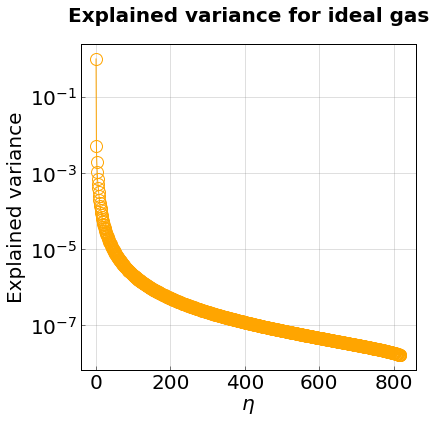

In [54]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca_ig.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'orange', markerfacecolor='None')  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.yscale('log')
#plt.ylim(0,0.01)

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Explained variance for ideal gas', y=1.05, fontdict = title_font)

plt.show()

### Explained variance from full model

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


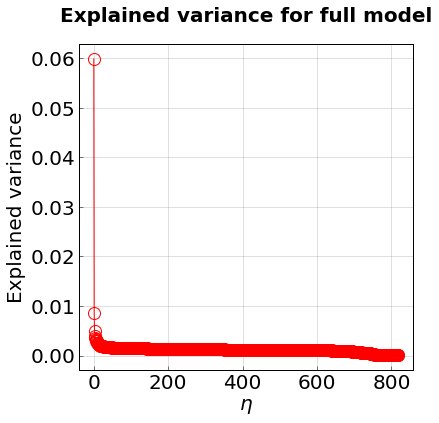

In [55]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'red', markerfacecolor='None')  
#plt.plot(incpca_ig.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'orange', markerfacecolor='None')  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.xscale('log')
#plt.ylim(0,0.1)
#plt.xlim(-1,20)
#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Explained variance for full model', y=1.05, fontdict = title_font)

plt.show()

### Principal component weights

Since the data is generally a result of two nested models the "true" intuitive feature weights are a matrix product of the two model component matrices

In [56]:
from numpy import dot

In [57]:
components = dot(incpca.components_, incpca_ig.components_)

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


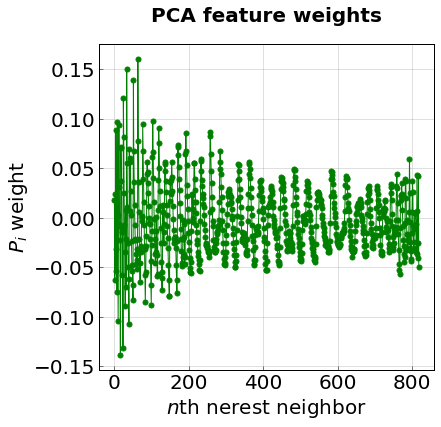

In [59]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1):
    p_data = components[i]
    plt.plot(range(len(p_data)), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.1,100)
#plt.ylim(-0.001,0.001)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.yscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

### Order parameters

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  app.launch_new_instance()


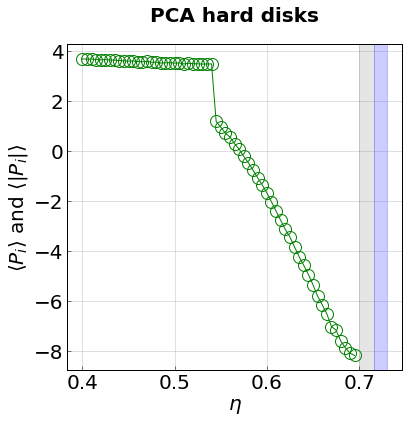

In [242]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    #p_data = OPs_std[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  app.launch_new_instance()


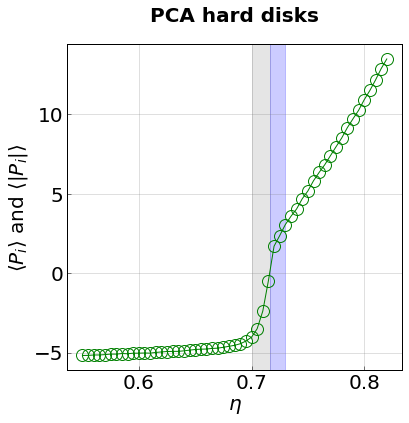

In [70]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_std[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-6,7)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


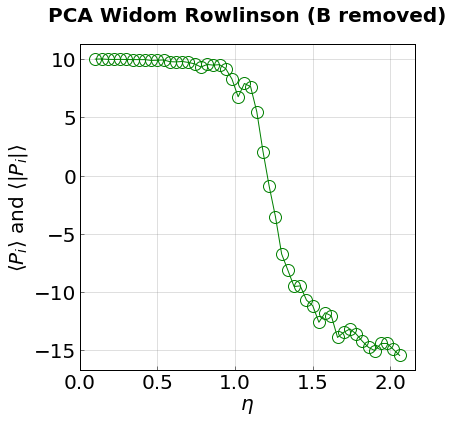

In [206]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_std[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA Widom Rowlinson (B removed)', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


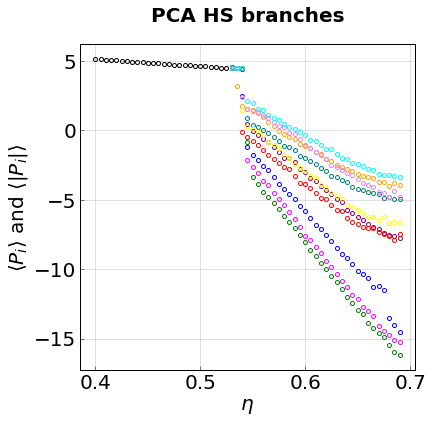

In [153]:
op = 0

colors = 200*['black', 'purple', 'orange', 'teal', 'green', 'red', 'yellow', 'magenta', 'blue', 'violet', 'cyan']
for i in range(len(OPs_by_id)):
    etas = etas_by_id[i]
    op_data = OPs_by_id[i][:,op]
    plt.plot(etas, op_data, marker='o', linewidth = 0.0, markersize=4, color=colors[i], markerfacecolor='None')

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.525, 0.56)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA HS branches', y=1.05, fontdict = title_font)

plt.show()

# THE END FOR NOW

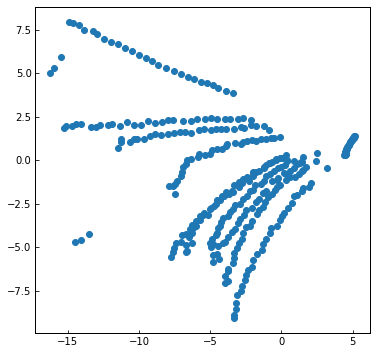

In [155]:
plt.scatter(OPs[:,0],OPs[:,1])

In [41]:
import gsd.hoomd
from numpy import mean, array

def ColorParticlesPCA(filename_gsd, filename_xyz, pca):
    frames = []
    traj = gsd.hoomd.open(name=filename, mode='rb')
    
    #static quantities
    box = traj[0].configuration.box
    D = traj[0].configuration.dimensions
    
    #loop over the configurations and stor in new format
    for snap in traj:
        #dynamic quantities
        diameters = snap.particles.diameter
        coords = snap.particles.position
        
        #check for a square box
        if (max(box[0:D]) - min(box[0:D]))/mean(box[0:D]) > 0.000000000001:
            raise Exception('Not a rectangle or square!!!')
            
        L = box[0]
        
        #get the particle types
        possible_types = snap.particles.types
        types = array([possible_types[type_id] for type_id in snap.particles.typeid])
        
        #create our new data structure
        frames.append({'coords': (coords[:,0:D]+L/2.0), 'diameters': diameters, 'types': types, 'L': L, 'D': D})
        

In [41]:

frames = ReadTraj('../hoomd_disks/trajectories_4000p_longer/trajectory_0.7000.gsd', 'gsd', False, False, [])

In [344]:
frames = ReadGSD('../hoomd_disks/trajectories_ww_4000p/trajectory_2.1800.gsd', randomize = False)

In [42]:
pc = 0
xyz_file_stream = open('op_labeled/hd_P{}.xyz'.format(pc), 'w')
for frame in frames[0:40]:
    coords = frame['coords']
    N = len(coords)
    L = frame['L']
    types = frame['types']
    
    #transform the data to features
    features = FrameToFeatures(frame, N_nn, ['distance'], particle_inc=1, nn_inc=nn_inc)
    ops = incpca.transform(incpca_ig.transform(features))[:,pc]
    
    #create header
    xyz_file_stream.write('{}\n'.format(N))
    xyz_file_stream.write(' L={}\n'.format(L))
    
    #joint data
    coords_ops_types = zip(coords, ops, types)
    for coord, op, type_ in coords_ops_types:
        xyz_file_stream.write('  {}    {}    {}    {}\n'.format(type_, coord[0], coord[1], op))
xyz_file_stream.close()
         

In [34]:
pc = 0
xyz_file_stream = open('op_labeled/feature_labeled_particles_2.1800_P{}.xyz'.format(pc), 'w')
for frame in frames[0:40]:
    coords = frame['coords']
    N = len(coords)
    L = frame['L']
    types = frame['types']
    
    #create header
    xyz_file_stream.write('{}\n'.format(N))
    xyz_file_stream.write(' L={}\n'.format(L))
    features = FrameToFeatures(frame, N_nn, ['distance'], particle_inc=1, nn_inc=nn_inc)
    
    #transform the data to features
    ops = (incpca.transform(features)[:,pc])
    #ops = types
    #print len(ops)
    
    #joint data
    coords_ops_types = zip(coords, ops, types)
    for coord, op, type_ in coords_ops_types:
        xyz_file_stream.write('  {}    {}    {}    0.0    {}\n'.format(type_, coord[0], coord[1], op))
xyz_file_stream.close()
                                 

In [56]:
frames[0]

{'D': 2, 'L': 38.414631, 'coords': array([[ 11.06319141,  37.75015259],
        [  8.64294338,   4.37904453],
        [ 38.39389038,   1.4232254 ],
        ..., 
        [ 16.68315125,  22.83090782],
        [ 23.82643127,   7.47303104],
        [ 11.08653927,   9.76377487]], dtype=float32), 'diameters': array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), 'types': array([u'A', u'A', u'A', ..., u'B', u'B', u'B'],
       dtype='<U1')}

## Testing WR mixture

In [88]:
from scipy.special import j0
from numpy import histogram, pi, power, rint
from numpy.linalg import norm
from numpy import trapz

#function for calculating the rdf
def RDF2D(frames, dr):
    M = len(frames)
    N = float(len(frames[0]['coords']))
    L = frames[0]['L']
    rho = float((N-1))/power(L, 2)
    r_edg = arange(0.0, L/2.0, dr)
    r = (r_edg[:-1] + r_edg[1:])/2.0
    hist = 0.0*r
    
    #loop over the frames
    for frame in frames:
        coords = frame['coords']

        #loop over each particle
        for coord in coords:
            #nearest neighbor coordinate wrapping
            Rpj = coord - coords
            Rpj = Rpj - rint(Rpj/L)*L
            Rpj = norm(Rpj, axis=1)
            
            #calculate the histogram
            hist = hist + histogram(Rpj, bins=r_edg)[0]
    
    #normalize out the number of frames and 
    hist = hist/float(M*(N-1))
    gr = hist/((2.0*pi*r*dr)*rho)
    
    return r, gr

#function for calculating the integral of h(r)
def PositionalSuceptibility2D(frames, dr, k):
    N = float(len(frames[0]['coords']))
    L = frames[0]['L']
    rho = float(N)/power(L, 2)
    
    d = float(L)/rint(L)
    k = 2.0*pi/d
    
    #compute the rdfs and calculate S(k0)
    r, gr = RDF2D(frames, dr)
    #Sk0 = 1.0 + 2.0*pi*rho*trapz(r*(gr-1.0)*j0(k*r))
    Sk0 = 1.0 + 2.0*pi*rho*trapz(r*abs(gr-1.0))
    
    return (Sk0, r, gr)

In [400]:
from scipy.special import j0
from numpy import sin

In [426]:
x, r, gr = PositionalSuceptibility2D(frames[0::100], 0.025, 2.0*pi)

In [262]:
from numpy import trapz

In [266]:
rho = float(len(frames[0]['coords']))/frames[0]['L']
trapz(2.0*pi*rho*(gr-1.0), r)

1062.9743662982394

In [277]:
rho = float(len(frames[0]['coords']))/frames[0]['L']
trapz(2.0*pi*rho*r*(gr-1.0), r)

510.23707895340073

In [49]:
r_grs = []
Xs = []

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)
        
        X, r, gr = PositionalSuceptibility2D(frames[0::200], 0.025, k=2.0*pi/1.0)
        Xs.append(X)
        r_grs.append([r, gr])

eta=0.55

eta=0.555

eta=0.56

eta=0.565

eta=0.57

eta=0.575

eta=0.58

eta=0.585

eta=0.59

eta=0.595

eta=0.6

eta=0.605

eta=0.61

eta=0.615

eta=0.62

eta=0.625

eta=0.63

eta=0.635

eta=0.64

eta=0.645

eta=0.65

eta=0.655

eta=0.66

eta=0.665

eta=0.67

eta=0.675

eta=0.68

eta=0.685

eta=0.69

eta=0.695

eta=0.7

eta=0.705

eta=0.71

eta=0.715

eta=0.72

eta=0.725

eta=0.73

eta=0.735

eta=0.74

eta=0.745

eta=0.75

eta=0.755

eta=0.76

eta=0.765

eta=0.77

eta=0.775

eta=0.78

eta=0.785

eta=0.79

eta=0.795

eta=0.8

eta=0.805

eta=0.81

eta=0.815

eta=0.82



In [87]:
frames = ReadGSD('../hoomd_disks/trajectories_ww_4000p/trajectory_1.5000.gsd', shuffle_data=True)

In [103]:
r, gr = RDF2D(frames[0::10], 0.15)

In [248]:
from copy import deepcopy
from numpy import power, rint, sqrt, sum, unique, repeat, arccos, dot, transpose, append, cos, sin, hstack, maximum, minimum, pi, array
from numpy.linalg import norm
from numpy.random import shuffle
from sklearn import preprocessing

#this generates NN features for the PCA analysis (or some other machine learning method as well)
def FrameToFeatures(frame, N_nn, method, particle_inc, nn_inc):
    #extract some relevant frames level details
    coords = deepcopy(frame['coords'])
    p_types = deepcopy(frame['types'])
    D = float(frame['D'])
    N = float(len(coords))
    V = power(frame['L'], D)
    normalizing_distance = power(V/N, 1.0/D)
    diameters = frame['diameters']
    diameters_scaled = frame['diameters']/frame['diameters'][0]
    
    frame_features = []
    combined_data = zip(coords, p_types)
    for particle, p_type in combined_data[0::particle_inc]:
        #nearest neighbor coordinate wrapping
        Rpj_v = particle - coords
        Rpj_v = Rpj_v - rint(Rpj_v/frame['L'])*frame['L']
        Rpj = (sqrt(sum(power(Rpj_v, 2.0), axis=1)))     
        
        #generate statistics for various nearest neighbors
        sorter = Rpj.argsort()
        Rpj = Rpj[sorter[::1]]
        
        #for composition calculations (the identity of the tagged particle is automatically included via the 0th entry)
        if 'composition' in method:
            p_types_one_hot = p_types[sorter[::1]]
            lb = preprocessing.LabelBinarizer()
            lb.fit(unique(p_types_one_hot))
            p_types_one_hot = lb.transform(p_types_one_hot).flatten()
        
        #chosen axis for measuring angles based on nearest neighbor
        if 'angular' in method:
            #sort the particle-particle vectors according to distance
            Rpj_v = Rpj_v[sorter[::1]]
            
            #normalize all of the vectors
            Rpj_v = Rpj_v/maximum(norm(Rpj_v, axis=1), 1.0e-10)[:,None]
            
            #find the unit x and y axis to base all angular details on using the 1st and 2nd nearest neighbors
            x_axis = Rpj_v[1] #this specifies the x direction to measure the angular elevation from
            y_axis = Rpj_v[2] - array([dot(Rpj_v[2], Rpj_v[1]), 0.0]) #this specifies the upper two quadrants
            y_axis = y_axis/norm(y_axis)
            
            #compute the raw angle between 0-pi that has unresolved upper and lower quadrants
            x_axis_T = transpose(x_axis)
            y_axis_T = transpose(y_axis)
            Tpj = arccos(minimum(maximum(dot(Rpj_v, x_axis_T), -0.9999999), 0.9999999))
            
            #determine if the vector points into the upper quadrant defined by the second nearest neighbor
            LQ = arccos(minimum(maximum(dot(Rpj_v, y_axis_T), -0.9999999), 0.9999999)) > pi/2.0
            
            #adjust the angle to upper or lower quadrants 
            Tpj[LQ] = 2.0*pi - Tpj[LQ]
        
        #possible feature options
        feature_batch = []
        if 'distance' in method:
            feature_batch.extend((Rpj[1:N_nn+1]/normalizing_distance)[0::nn_inc])
        if 'composition' in method:
            feature_batch.extend(p_types_one_hot[0:N_nn+1][0::nn_inc])
        if 'angular' in method:
            feature_batch.extend(append(cos(Tpj[2:N_nn+1])[0::nn_inc], 
                                        sin(Tpj[2:N_nn+1])[0::nn_inc], axis=0))
            
        frame_features.append(feature_batch)

    return array(frame_features)

#this converts an entire trajectory into features
def TrajectoryToFeatures(frames, N_nn, method, particle_inc, nn_inc):
    #print filename
    features = []
    for frame in frames:        
        features_sp = FrameToFeatures(frame, N_nn, method, particle_inc, nn_inc)
        for feature in features_sp:
            features.append(feature)
    return features

### WR mixture

In [352]:
from copy import deepcopy
from numpy import power, rint, sqrt, sum, unique, repeat, arccos, dot, transpose, append, cos, sin, hstack, maximum, minimum, pi, array
from numpy.linalg import norm
from numpy.random import shuffle
from sklearn import preprocessing

#this generates NN features for the PCA analysis (or some other machine learning method as well)
def FrameToFeaturesComposition(frame, probe_particle_indicies):
    #extract some relevant frames level details
    coords = deepcopy(frame['coords'])
    p_types = deepcopy(frame['types'])
    D = float(frame['D'])
    N = float(len(coords))
    V = power(frame['L'], D)
    normalizing_distance = power(V/N, 1.0/D)
    diameters = frame['diameters']
    diameters_scaled = frame['diameters']/frame['diameters'][0]
    
    #reduce the coords down to only those we care about
    coords = coords[probe_particle_indicies]

    #build up the features considering only the probes
    frame_features = []
    for particle in coords:
        #nearest neighbor coordinate wrapping
        Rpj_v = particle - coords
        Rpj_v = Rpj_v - rint(Rpj_v/frame['L'])*frame['L']
        Rpj = (sqrt(sum(power(Rpj_v, 2.0), axis=1)))     
        
        #extend the feature vector stacking the particle side by side
        frame_features.extend(Rpj/normalizing_distance)

    return array(frame_features)

#this converts an entire trajectory into features
def TrajectoryToFeaturesComposition(frames, probe_particle_indicies):
    features = []
    for frame in frames:        
        features.append(FrameToFeaturesComposition(frame, probe_particle_indicies))
    return features

In [418]:
len(arange(0,4096,1)[0::40])

103

In [34]:
#specify what data to read in and process
file_data = [(arange(0.550, 0.690001, 0.005), '../hoomd_disks/trajectories_4000p'), 
             (arange(0.695, 0.820001, 0.005),'../hoomd_disks/trajectories_4000p_longer')]
probe_particle_indicies = arange(0,4096,1)[0::40]
split=1

In [483]:
#specify what data to read in and process
file_data = [(arange(0.100, 2.06001, 0.04), '../hoomd_disks/trajectories_ww_4000p')]
probe_particle_indicies = arange(0,4096,1)[0::40]
split=4

In [17]:
#specify what data to read in and process
file_data = [(arange(0.100, 3.50001, 0.04), '../hoomd_disks/trajectories_ww_4000p_0.25')]
probe_particle_indicies = arange(0,4096,1)[0::200]
split=1

In [19]:
incpca = IncrementalPCA(n_components=16, whiten=False)

frames = None
features = None
split_features = None

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)[0::400]
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeaturesComposition(frames_partial, probe_particle_indicies=probe_particle_indicies)
            incpca.partial_fit(features_partial)
            count = count + 1
            print count
        frames_split = None

eta=0.1

1
eta=0.14

1
eta=0.18

1
eta=0.22

1
eta=0.26

1
eta=0.3

1
eta=0.34

1
eta=0.38

1
eta=0.42

1
eta=0.46

1
eta=0.5

1
eta=0.54

1
eta=0.58

1
eta=0.62

1
eta=0.66

1
eta=0.7

1
eta=0.74

1
eta=0.78

1
eta=0.82

1
eta=0.86

1
eta=0.9

1
eta=0.94

1
eta=0.98

1
eta=1.02

1
eta=1.06

1
eta=1.1

1
eta=1.14

1
eta=1.18

1
eta=1.22

1
eta=1.26

1
eta=1.3

1
eta=1.34

1
eta=1.38

1
eta=1.42

1
eta=1.46

1
eta=1.5

1
eta=1.54

1
eta=1.58

1
eta=1.62

1
eta=1.66

1
eta=1.7

1
eta=1.74

1
eta=1.78

1
eta=1.82

1
eta=1.86

1
eta=1.9

1
eta=1.94

1
eta=1.98

1
eta=2.02

1
eta=2.06

1
eta=2.1

1
eta=2.14

1
eta=2.18

1
eta=2.22

1
eta=2.26

1
eta=2.3

1
eta=2.34

1
eta=2.38

1
eta=2.42

1
eta=2.46

1
eta=2.5

1
eta=2.54

1
eta=2.58

1
eta=2.62

1
eta=2.66

1
eta=2.7

1
eta=2.74

1
eta=2.78

1
eta=2.82

1
eta=2.86

1
eta=2.9

1
eta=2.94

1
eta=2.98

1
eta=3.02

1
eta=3.06

1
eta=3.1

1
eta=3.14

1
eta=3.18

1
eta=3.22

1
eta=3.26

1
eta=3.3

1
eta=3.34

1
eta=3.38

1
eta=3.42

1
eta=3.46


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


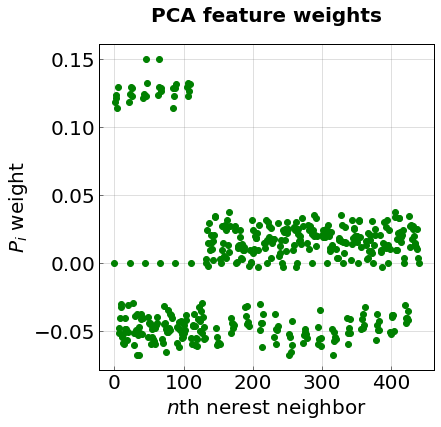

In [23]:
#highlight the transition region if found
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plt.axvspan(0.716, 0.716001, alpha=1, color='black')
#plt.axvspan(0.781, 0.781001, alpha=1, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1):
    p_data = incpca.components_[i]
    plt.plot(range(len(incpca.components_[0])), p_data, marker='o', linewidth = 0.0, markersize=6, color = colors[i])
    #p_data = OPs_non_abs[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 2.0, markersize=10, color = colors[i])
#plt.plot(etas, num_defects, marker='o', linewidth = 2.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0,103)
#plt.ylim(-1,0)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

In [26]:
OPs = []
frames = None
features = None
raw_OPs = []

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)[0::400]
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeaturesComposition(frames_partial, probe_particle_indicies=probe_particle_indicies)
            transformed_features_partial = incpca.transform(features_partial)
            means.append(mean(transformed_features_partial, axis=0))
            raw_OPs_single.append(transformed_features_partial)
            count = count + 1
            print count
            
        means = array(means)
        op = mean(means, axis=0)
        OPs.append(op)
        raw_OPs.append(raw_OPs_single)
    
OPs = array(OPs)        

eta=0.1

1
eta=0.14

1
eta=0.18

1
eta=0.22

1
eta=0.26

1
eta=0.3

1
eta=0.34

1
eta=0.38

1
eta=0.42

1
eta=0.46

1
eta=0.5

1
eta=0.54

1
eta=0.58

1
eta=0.62

1
eta=0.66

1
eta=0.7

1
eta=0.74

1
eta=0.78

1
eta=0.82

1
eta=0.86

1
eta=0.9

1
eta=0.94

1
eta=0.98

1
eta=1.02

1
eta=1.06

1
eta=1.1

1
eta=1.14

1
eta=1.18

1
eta=1.22

1
eta=1.26

1
eta=1.3

1
eta=1.34

1
eta=1.38

1
eta=1.42

1
eta=1.46

1
eta=1.5

1
eta=1.54

1
eta=1.58

1
eta=1.62

1
eta=1.66

1
eta=1.7

1
eta=1.74

1
eta=1.78

1
eta=1.82

1
eta=1.86

1
eta=1.9

1
eta=1.94

1
eta=1.98

1
eta=2.02

1
eta=2.06

1
eta=2.1

1
eta=2.14

1
eta=2.18

1
eta=2.22

1
eta=2.26

1
eta=2.3

1
eta=2.34

1
eta=2.38

1
eta=2.42

1
eta=2.46

1
eta=2.5

1
eta=2.54

1
eta=2.58

1
eta=2.62

1
eta=2.66

1
eta=2.7

1
eta=2.74

1
eta=2.78

1
eta=2.82

1
eta=2.86

1
eta=2.9

1
eta=2.94

1
eta=2.98

1
eta=3.02

1
eta=3.06

1
eta=3.1

1
eta=3.14

1
eta=3.18

1
eta=3.22

1
eta=3.26

1
eta=3.3

1
eta=3.34

1
eta=3.38

1
eta=3.42

1
eta=3.46


In [39]:
from numpy import std, abs, power
from scipy.stats import moment

OPs = []
OPs_std = []
OPs_abs = []
OPs_third = []
for single_eta in raw_OPs:
    merged_data = []
    for split in single_eta:
        merged_data.extend(split)
    
    OPs.append(mean((split), axis=0))
    OPs_std.append(std(split, axis=0))
    OPs_abs.append(mean(abs(split), axis=0))
    OPs_third.append(moment(split, 4, axis=0))

OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)
OPs_third = array(OPs_third)

In [28]:
OPs = []
OPs_std = []
OPs_abs = []

for single_eta in raw_OPs:
    merged_data = []
    for split in single_eta:
        merged_data.extend(split)

    OPs.append(mean(merged_data, axis=0))
    OPs_std.append(std(merged_data, axis=0))
    OPs_abs.append(mean(abs(merged_data), axis=0))
    
OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


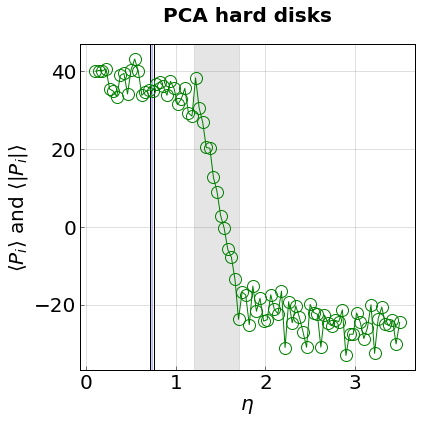

In [36]:
#highlight the transition region if found
plt.axvspan(1.2, 1.7, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

plt.axvspan(0.716, 0.716001, alpha=1, color='black')
plt.axvspan(0.76, 0.76001, alpha=1, color='black')

#plt.axvspan(0.72, 0.72001, alpha=10, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_abs[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)

#plt.xlim(0.10, 2.1)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

### Old stuff

In [314]:
a = array([[1,1,1],[2,2,2],[3,3,3],[4,4,4]])
b = array([1,1,1])

In [315]:
a - b

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

## 3D hard spheres

In [65]:
from numpy import mean, array, unique, concatenate, power, std
from numpy.random import shuffle, rand
from copy import deepcopy
import re

def ReadXYZ(filename, N, N_types, shuffle_data=True, randomize=False):
    #regex used to parse the data
    xyz_regex = r'(?:([a-zA-Z]+)\s+([0-9\.e\-\+]+)\s+([0-9\.e\-\+]+)\s+([0-9\.e\-\+]+)\s+([0-9\.e\-\+]+))'
    L_regex = r'(?:L\s*=\s*([0-9\.e\-\+]+))'
    
    #read in the data and check for volume fraction consistency
    eta_stats = []
    with open(filename, "r") as ins:
        frames = [] #xyz and diameter
        coords, coords_count = [], 0
        diameters = []
        types = []
        L = None
        for line in ins:
            search = re.search(xyz_regex, line)
            if search and coords_count < N:
                coords.append(array([float(search.group(2)), float(search.group(3)), float(search.group(4))]))
                diameters.append(2.0*float(search.group(5)))
                types.append(search.group(1))
                coords_count = coords_count + 1
            elif coords:
                coords = array(coords)
                diameters = array(diameters)
                types = array(types)
                sorter = diameters.argsort()
                coords = coords[sorter]
                diameters = diameters[sorter]
                types = types[sorter]
                #replace with random positions if randomize is selected (for comparing to randomized PCA result and useful information content)
                if randomize:
                    coords = L*rand(len(coords), len(coords[0]))
                frames.append({'coords': array(coords), 'diameters': array(diameters), 'types': array(types), 'L': L, 'D': len(coords[0])})
                eta_stats.append(sum(power(diameters, 3.0))/power(L, 3.0))
                coords, coords_count = [], 0
                diameters = []
                types = []
                L = None
                search_L = re.search(L_regex, line)
                if search_L:
                    L = float(search_L.group(1))
            else:
                search_L = re.search(L_regex, line)
                if search_L:
                    L = float(search_L.group(1))
                    
        #append final frame
        coords = array(coords)
        diameters = array(diameters)
        types = array(types)
        sorter = diameters.argsort()
        coords = coords[sorter]
        diameters = diameters[sorter]
        types = types[sorter]
        #replace with random positions if randomize is selected (for comparing to randomized PCA result and useful information content)
        if randomize:
            coords = L*rand(len(coords), len(coords[0]))
        frames.append({'coords': array(coords), 'diameters': array(diameters), 'types': array(types), 'L': L, 'D': len(coords[0])})
        eta_stats.append(sum(power(diameters, 3.0))/power(L, 3.0))
        
    #check that the volume fraction is consistent accross all frames
    if std(eta_stats)/mean(eta_stats) > 0.0000001:
        raise Exception('Volume fractions seem inconsistent accross frames!!!')
        
    #perform random shuffle of identical particles coordinates to help facilitate learning    
    if shuffle_data:
        shuffled_frames = []
        for frame in frames:
            #extract local copies for organizational convenience
            coords = frame['coords']
            diameters = frame['diameters']
            types = frame['types']
            L = frame['L']
            
            #prepare for shuffle
            coords_shuffled = None
            unique_types, start, count = unique(types, return_index=True, return_inverse=False, return_counts=True, axis=None)
            start__end = zip(start, start+count)
            #print types
            
            #check for errors
            if len(start__end) != len(unique_types):
                raise Exception('Bad data!!!')
            
            #do the shuffling
            for start, end in start__end:
                grouped = deepcopy(coords[start:end])
                shuffle(grouped)
                if coords_shuffled is not None:
                    coords_shuffled = concatenate((coords_shuffled, grouped), axis=0)
                else:
                    coords_shuffled = deepcopy(grouped)
            shuffled_frames.append({'coords': array(coords_shuffled), 'diameters': array(diameters), 'types': array(types), 'L': L, 'D': len(coords_shuffled[0])})
        
        #set the data
        frames = shuffled_frames
        shuffled_frames = []
        
        
    #perform a check that everything was read in and/or processed correctly
    for frame in frames:
        if len(frame['coords']) != N or len(frame['diameters']) != N or frame['L'] is None or len(set(types)) != N_types:
            raise Exception('Bad data!!!')
        else:
            continue
    
    return frames

In [121]:
N_nn = 300 #5000 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
particle_inc = 50 #skip this many particles in generating features
nn_inc = 1  #reduces the number of nearest neighbors to include as features
method = ['distance']

In [119]:
#specify what data to read in and process
file_data = [(range(1,51), '/home/ryanj/Documents/research_projects/polydisperse_simulations/fluid_only/300p_sims/inc_mono')]

In [638]:
frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=True)

In [126]:
filename = '/home/ryanj/Documents/research_projects/polydisperse_simulations/fluid_only/300p_sims/inc_mono/step_50/trajectory.xyz'
frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=True)

In [639]:
frames_nr = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=False)

In [120]:
etas=arange(0.4, 0.645001, 0.005)

In [122]:
n_components_ig = 299 #96  #for this the more the better, however, 50 is probably enough

In [123]:
randomize = True
incpca_ig = IncrementalPCA(n_components=n_components_ig, whiten=True)

frames = None
features = None
split_features = None

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/step_{}/trajectory.xyz".format(file_base, eta)
        frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            incpca_ig.partial_fit(features_partial)
            count = count + 1
            print count
        frames_split = None

eta=1
1
eta=2
1
eta=3
1
eta=4
1
eta=5
1
eta=6
1
eta=7
1
eta=8
1
eta=9
1
eta=10
1
eta=11
1
eta=12
1
eta=13
1
eta=14
1
eta=15
1
eta=16
1
eta=17
1
eta=18
1
eta=19
1
eta=20
1
eta=21
1
eta=22
1
eta=23
1
eta=24
1
eta=25
1
eta=26
1
eta=27
1
eta=28
1
eta=29
1
eta=30
1
eta=31
1
eta=32
1
eta=33
1
eta=34
1
eta=35
1
eta=36
1
eta=37
1
eta=38
1
eta=39
1
eta=40
1
eta=41
1
eta=42
1
eta=43
1
eta=44
1
eta=45
1
eta=46
1
eta=47
1
eta=48
1
eta=49
1
eta=50
1


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if __name__ == '__main__':


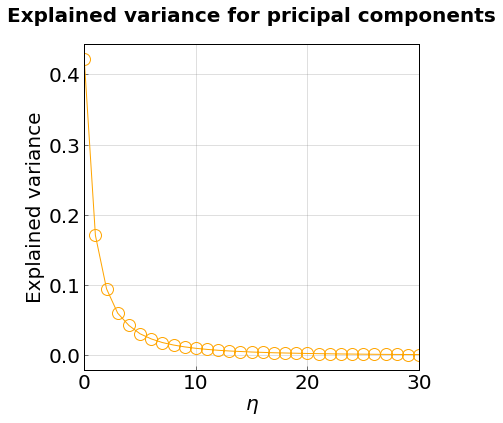

In [124]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca_ig.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'orange', markerfacecolor='None')  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
plt.xlim(0,30)

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Explained variance for pricipal components', y=1.05, fontdict = title_font)

plt.show()

In [126]:
sum(incpca_ig.explained_variance_ratio_[0:299])

0.99999999990145572

In [109]:
n_components = 299 #96 #this number will not affect the quality of the result just the computation time and amount of info returned
n_ig = 50# 20

In [127]:
randomize = False
incpca = IncrementalPCA(n_components=n_components_ig , whiten=False)

frames = None
features = None
split_features = None

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/step_{}/trajectory.xyz".format(file_base, eta)
        frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            #features_partial_ig_projection = incpca_ig.inverse_transform(incpca_ig.transform(features_partial))
            #incpca.partial_fit(features_partial - features_partial_ig_projection)
            incpca.partial_fit(incpca_ig.transform(features_partial))
            
            count = count + 1
            print count
        frames_split = None

eta=1
1
eta=2
1
eta=3
1
eta=4
1
eta=5
1
eta=6
1
eta=7
1
eta=8
1
eta=9
1
eta=10
1
eta=11
1
eta=12
1
eta=13
1
eta=14
1
eta=15
1
eta=16
1
eta=17
1
eta=18
1
eta=19
1
eta=20
1
eta=21
1
eta=22
1
eta=23
1
eta=24
1
eta=25
1
eta=26
1
eta=27
1
eta=28
1
eta=29
1
eta=30
1
eta=31
1
eta=32
1
eta=33
1
eta=34
1
eta=35
1
eta=36
1
eta=37
1
eta=38
1
eta=39
1
eta=40
1
eta=41
1
eta=42
1
eta=43
1
eta=44
1
eta=45
1
eta=46
1
eta=47
1
eta=48
1
eta=49
1
eta=50
1


In [131]:
frames = None
features = None
raw_OPs = []

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/step_{}/trajectory.xyz".format(file_base, eta)
        frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            #features_partial_ig_projection = incpca_ig.inverse_transform(incpca_ig.transform(features_partial))
            #transformed_features_partial = incpca.transform(features_partial - features_partial_ig_projection)
            #raw_OPs_single.append(transformed_features_partial)
            transformed_features_partial = incpca.transform(incpca_ig.transform(features_partial))
            raw_OPs_single.append(transformed_features_partial)
            count = count + 1
            print count
            
        raw_OPs.append(raw_OPs_single)  

eta=1
1
eta=2
1
eta=3
1
eta=4
1
eta=5
1
eta=6
1
eta=7
1
eta=8
1
eta=9
1
eta=10
1
eta=11
1
eta=12
1
eta=13
1
eta=14
1
eta=15
1
eta=16
1
eta=17
1
eta=18
1
eta=19
1
eta=20
1
eta=21
1
eta=22
1
eta=23
1
eta=24
1
eta=25
1
eta=26
1
eta=27
1
eta=28
1
eta=29
1
eta=30
1
eta=31
1
eta=32
1
eta=33
1
eta=34
1
eta=35
1
eta=36
1
eta=37
1
eta=38
1
eta=39
1
eta=40
1
eta=41
1
eta=42
1
eta=43
1
eta=44
1
eta=45
1
eta=46
1
eta=47
1
eta=48
1
eta=49
1
eta=50
1


In [132]:
OPs = []
OPs_std = []
OPs_abs = []

i = 0
for single_eta in raw_OPs:
    print i
    merged_data = []
    for split_ in single_eta:
        merged_data.extend(split_)
    
    #OPs.append(mean((split), axis=0))
    #OPs_std.append(std(split, axis=0))
    #OPs_abs.append(mean(abs(split), axis=0))

    OPs.append(mean(merged_data, axis=0))
    OPs_std.append(std(merged_data, axis=0))
    OPs_abs.append(mean(abs(merged_data), axis=0))
    i = i + 1
    
OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


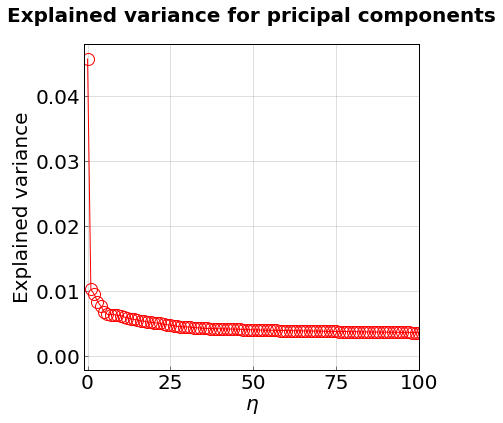

In [133]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'red', markerfacecolor='None')  
#plt.plot(incpca_ig.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=5, color = 'orange', markerfacecolor='None')  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.xscale('log')
#plt.ylim(0.0,0.2)
plt.xlim(-1,100)
#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Explained variance for pricipal components', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  app.launch_new_instance()


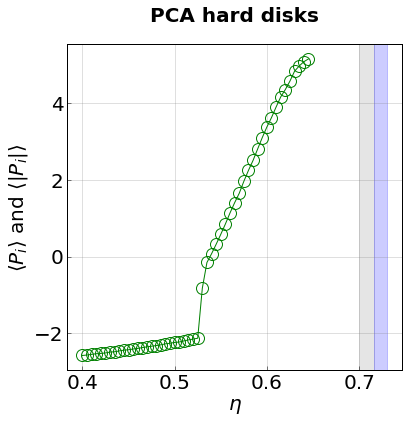

In [143]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_abs[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


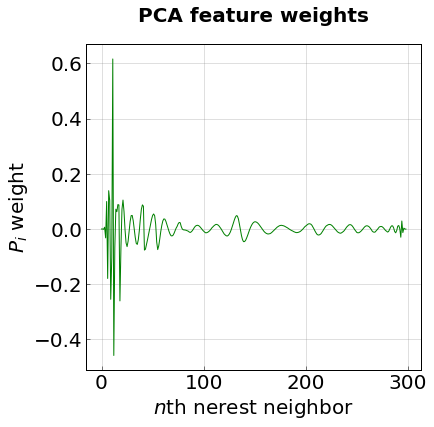

In [115]:
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plt.axvspan(0.716, 0.716001, alpha=1, color='black')
#plt.axvspan(0.781, 0.781001, alpha=1, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1):
    p_data = incpca_ig.components_[i]
    #plt.plot(range(len(incpca_ig.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i]) 
    p_data = incpca.components_[i]
    plt.plot(range(len(incpca.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=0, color = colors[i])  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.1,100)
#plt.ylim(-0.001,0.001)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

In [148]:
filename = '/home/ryanj/Documents/research_projects/polydisperse_simulations/fluid_only/300p_sims/inc_mono/step_20/trajectory.xyz'
frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=False)

KeyboardInterrupt: 

In [140]:
r, gr = RDF(frames[0::100], 0.01)

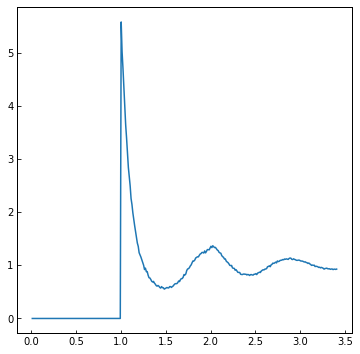

In [141]:
plt.plot(r[1:],gr[1:])
#plt.ylim(0,5)

In [149]:
dr = 0.01
skip_frames = 100
pos_spts = []

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/step_{}/trajectory.xyz".format(file_base, eta)
        frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=randomize)
        pos_spt, _, _ = PositionalSuceptibility2D(frames[0::skip_frames], dr=dr)
        pos_spts.append(pos_spt)

eta=1
eta=2
eta=3
eta=4
eta=5
eta=6
eta=7
eta=8
eta=9
eta=10
eta=11
eta=12
eta=13
eta=14
eta=15
eta=16
eta=17
eta=18
eta=19
eta=20
eta=21
eta=22
eta=23
eta=24
eta=25
eta=26
eta=27
eta=28
eta=29
eta=30
eta=31
eta=32
eta=33
eta=34
eta=35
eta=36
eta=37
eta=38
eta=39
eta=40
eta=41
eta=42
eta=43
eta=44
eta=45
eta=46
eta=47
eta=48
eta=49
eta=50


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # This is added back by InteractiveShellApp.init_path()


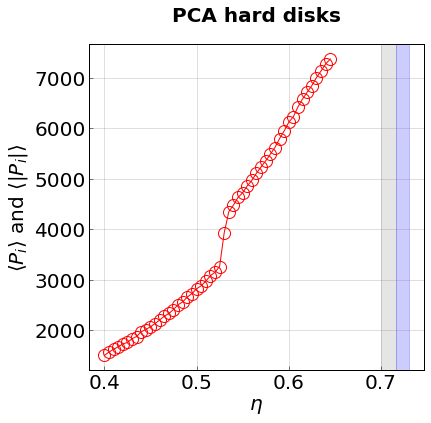

In [151]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plot the principal components
plt.plot(etas, pos_spts, marker='o', linewidth = 1.0, markersize=12, color = 'red', markerfacecolor='None')

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

In [157]:
n = 64
float(len(range(n*n/4, n*n)))/float(len(range(0, n*n)))

0.75

In [161]:
arange(0.1, 3.50001, 0.04)

array([ 0.1 ,  0.14,  0.18,  0.22,  0.26,  0.3 ,  0.34,  0.38,  0.42,
        0.46,  0.5 ,  0.54,  0.58,  0.62,  0.66,  0.7 ,  0.74,  0.78,
        0.82,  0.86,  0.9 ,  0.94,  0.98,  1.02,  1.06,  1.1 ,  1.14,
        1.18,  1.22,  1.26,  1.3 ,  1.34,  1.38,  1.42,  1.46,  1.5 ,
        1.54,  1.58,  1.62,  1.66,  1.7 ,  1.74,  1.78,  1.82,  1.86,
        1.9 ,  1.94,  1.98,  2.02,  2.06,  2.1 ,  2.14,  2.18,  2.22,
        2.26,  2.3 ,  2.34,  2.38,  2.42,  2.46,  2.5 ,  2.54,  2.58,
        2.62,  2.66,  2.7 ,  2.74,  2.78,  2.82,  2.86,  2.9 ,  2.94,
        2.98,  3.02,  3.06,  3.1 ,  3.14,  3.18,  3.22,  3.26,  3.3 ,
        3.34,  3.38,  3.42,  3.46,  3.5 ])

# Analyze single trajectory and identify regions

In [259]:
filename = '/home/ryanj/Documents/hoomd-examples/hoomd_spheres/trajectories_4000p/trajectory_0.6200.gsd'

In [288]:
N_nn = 500 #5000 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
particle_inc = 10 #skip this many particles in generating features
nn_inc = 1  #reduces the number of nearest neighbors to include as features
method = ['distance']

In [289]:
n_components_single = 499

In [290]:
#frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=True)
frames = ReadGSD(filename, shuffle_data=True, randomize=True, remove_types=[])[:100]
features = TrajectoryToFeatures(frames, 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=particle_inc, 
                                nn_inc=nn_inc)
incpca_single_ig = IncrementalPCA(n_components=n_components_single, whiten=True)
incpca_single_ig.partial_fit(features)

IncrementalPCA(batch_size=None, copy=True, n_components=499, whiten=True)

In [291]:
#frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=False)
frames = ReadGSD(filename, shuffle_data=True, randomize=False, remove_types=[])[:100]
features = TrajectoryToFeatures(frames, 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=particle_inc, 
                                nn_inc=nn_inc)
incpca_single = IncrementalPCA(n_components=n_components_single, whiten=False)
incpca_single.partial_fit(incpca_single_ig.transform(features))

IncrementalPCA(batch_size=None, copy=True, n_components=499, whiten=False)

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


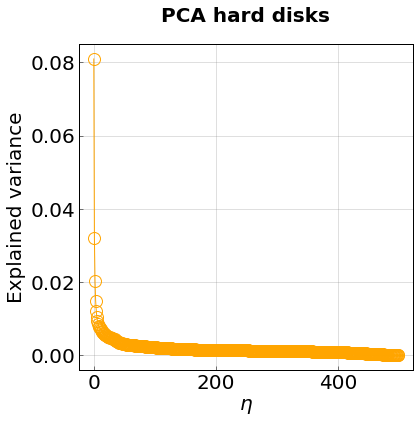

In [299]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#plt.plot(incpca_single_ig.explained_variance_ratio_, marker='o', linewidth = 1.0, markersize=12, color = 'red', markerfacecolor='None')
plt.plot(incpca_single.explained_variance_ratio_, marker='o', linewidth = 1.0, markersize=12, color = 'orange', markerfacecolor='None')
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.ylim(0.001,1.0)
#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


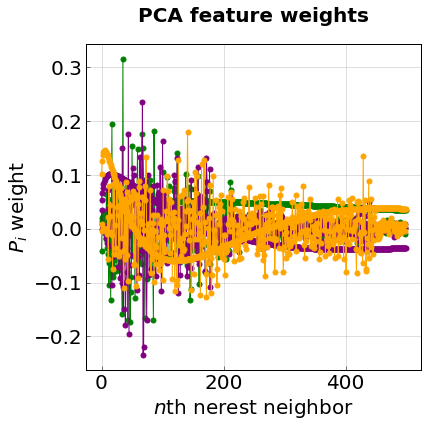

In [297]:
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plt.axvspan(0.716, 0.716001, alpha=1, color='black')
#plt.axvspan(0.781, 0.781001, alpha=1, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,3):
    p_data = incpca_single_ig.components_[i]
    plt.plot(range(len(incpca_single_ig.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])  
    p_data = incpca_single.components_[i]
    plt.plot(range(len(incpca_single.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.1,100)
#plt.ylim(-0.001,0.001)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

In [75]:
pc = 0
xyz_file_stream = open('op_labeled/hs_P{}.xyz'.format(pc), 'w')
for frame in frames[0:40]:
    coords = frame['coords']
    N = len(coords)
    L = frame['L']
    types = frame['types']
    
    #transform the data to features
    ops = incpca_single.transform(incpca_single_ig.transform(features))[:,pc]
    
    #create header
    xyz_file_stream.write('{}\n'.format(N))
    xyz_file_stream.write(' L={}\n'.format(L))
    
    #joint data
    coords_ops_types = zip(coords, ops, types)
    for coord, op, type_ in coords_ops_types:
        xyz_file_stream.write('  {}    {}    {}    {}    {}\n'.format(type_, coord[0], coord[1], coord[2], op))
xyz_file_stream.close()
                                 

KeyboardInterrupt: 

In [ ]:
frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=True)
features = TrajectoryToFeatures(frames, 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=particle_inc, 
                                nn_inc=nn_inc)
incpca_single_ig = IncrementalPCA(n_components=n_components_single, whiten=False)
incpca_single_ig.partial_fit(features)

frames = None

frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=False)
features = TrajectoryToFeatures(frames, 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=particle_inc, 
                                nn_inc=nn_inc)
incpca_single_ig = IncrementalPCA(n_components=n_components_single, whiten=False)
incpca_single_ig.partial_fit(features)

In [127]:
pcs = 

10000

In [ ]:
plt.plot()

In [295]:
#frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=False, randomize=False)
#frames = ReadGSD(filename, shuffle_data=True, randomize=False, remove_types=[])[:100]
features = TrajectoryToFeatures(frames[::10], 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=1, 
                                nn_inc=1)
pcs = incpca_single.transform(incpca_single_ig.transform(features))

In [274]:
pcs_avg = 0.0
count = 0.0
for frame in frames[0::10]:
    if int(count) % 100 == 0:
        print count
    features = TrajectoryToFeatures([frame], 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=1, 
                                nn_inc=1)
    pcs_avg = pcs_avg + incpca_single.transform(incpca_single_ig.transform(features))
    count  =  count + 1.0
pcs_avg = pcs_avg / count    

0.0


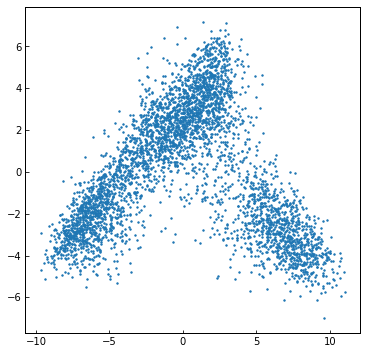

In [273]:
plt.scatter(pcs_avg[:,0][0::1], pcs_avg[:,1][0::1], s=2)
plt.rcParams["figure.figsize"] = [6,6]

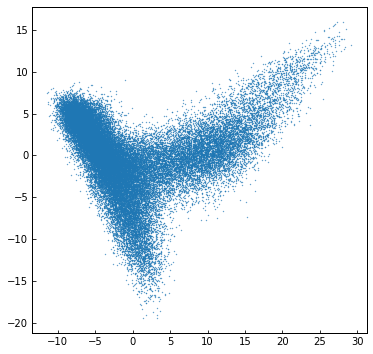

In [300]:
plt.scatter(pcs[:,0][0::1], pcs[:,1][0::1], s=0.1)
plt.rcParams["figure.figsize"] = [6,6]

In [111]:
len(pcs)

300

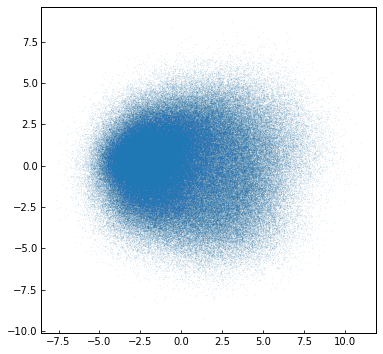

In [91]:
plt.scatter(pcs[:,1][0::1], pcs[:,2][0::1], s=0.001)
plt.rcParams["figure.figsize"] = [6,6]

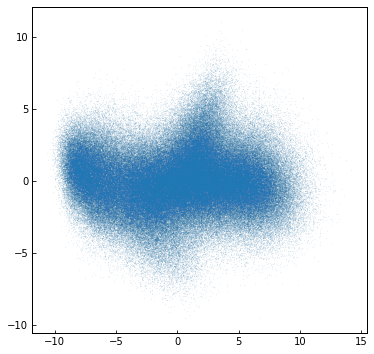

In [82]:
plt.scatter(pcs[:,0][0::1], pcs[:,3][0::1], s=0.001)
plt.rcParams["figure.figsize"] = [6,6]

In [43]:
1023/116

8

In [45]:
116*8

928

In [95]:
a = array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
#a = array([1,2,3,4,5])

In [96]:
from numpy import append

In [99]:
samples = 3

In [100]:
a[0::len(a)/samples+1][0:samples]

array([ 1,  7, 13])

In [45]:
from numpy import unique

In [46]:
types = array(['A','A','B','A','B','A','B','B','B'])

In [51]:
unique_types, start, count = unique(types, return_index=True, return_inverse=False, return_counts=True, axis=None)
start__end = zip(start, start+count)

In [52]:
start__end

[(0, 4), (2, 7)]

In [50]:
count

array([4, 5])

In [ ]:
coords_shuffled = None
unique_types, start, count = unique(types, return_index=True, return_inverse=False, return_counts=True, axis=None)
start__end = zip(start, start+count)

In [ ]:
encountered = set([])
last_type = None
for entry in types:
    if entry != last_type:
        if last_type in encountered:
            raise error
        else:
            encountered
        
    if entry in encountered:
        
        
    

In [ ]:
#this generates NN features for the PCA analysis (or some other machine learning method as well)
def FrameToFeaturesMultiParticle(frame, N_nn, nn_inc, probe_particle_indicies):
    #extract some relevant frames level details
    coords = deepcopy(frame['coords'])
    D = float(frame['D'])
    N = float(len(coords))
    V = power(frame['L'], D)
    normalizing_distance = power(V/N, 1.0/D)
    
    frame_features = []
    for particle in coords[probe_particle_indicies]:
        #nearest neighbor coordinate wrapping
        Rpj_v = particle - coords
        Rpj_v = Rpj_v - rint(Rpj_v/frame['L'])*frame['L']
        Rpj = (sqrt(sum(power(Rpj_v, 2.0), axis=1)))     
        
        #generate statistics for various nearest neighbors
        sorter = Rpj.argsort()
        Rpj = Rpj[sorter[::1]]
        
        #create features that correspond to probe particles and their nearest neighbors
        frame_features.append((Rpj[1:N_nn+1])[0::nn_inc])
        frame_features = sorted(frame_features)

    return array(frame_features).flatten()

#this converts an entire trajectory into features
def TrajectoryToFeaturesMultiParticle(frames, N_nn, nn_inc, probe_particle_indicies):
    #print filename
    features = []
    for frame in frames:        
        features_sp = FrameToFeaturesMultiParticle(frame, N_nn, method, particle_inc, nn_inc)
        for feature in features_sp:
            features.append(feature)
    return features

In [27]:
sorted([[1,2,3,4],[2,3,1,0],[1,1,1,4],[3,0,2,2]])

[[1, 1, 1, 4], [1, 2, 3, 4], [2, 3, 1, 0], [3, 0, 2, 2]]

In [26]:
a